# 1D RNN Position Model

Gradient clipping for the win!

### Hyperparameters

In [1]:
NUM_ITERS = 5000

NUM_CLASSES = 2
NUM_HIDDEN = 20
ROLLOUT = 10
LEARNING_RATE = 0.005
REGULARIZER = 0

### Load Data

In [2]:
%store -r data_points_1d

df = data_points_1d
sideways = df.T

X, Y = np.array(sideways.ix[['pos']]), np.array(sideways.ix['label']).astype(int)

N, T = X.shape

# ROLLOUT = T

### Train

In [3]:
from rnn.model import RecurrentNeuralNetwork
from rnn.support import Snapshot

rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, learning_rate=LEARNING_RATE, rollout=ROLLOUT, regularizer=REGULARIZER, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        rnn.learn()
        yield rnn.info
        
states = list(states(NUM_ITERS))

clf = pd.DataFrame(states, columns=Snapshot._fields)

### Hidden State Over the Two Shots

In [4]:
from ipywidgets import interact, fixed

@interact(view_index=(0, NUM_ITERS-1))
def plot(view_index):
    s = states[view_index]
    
    hiddens_block = np.hstack([hidden for t, hidden in s.hiddens.items()])
    
    print(hiddens_block.shape)
    
#     pd.DataFrame({'hiddens': hiddens_block.reshape(ROLLOUT+1),
#                   'X': np.hstack([X.reshape(ROLLOUT), X[:]])}).plot()
    
#     plt.imshow(hiddens_block, interpolation='nearest')

(20, 11)


### Magnitude of Parameters

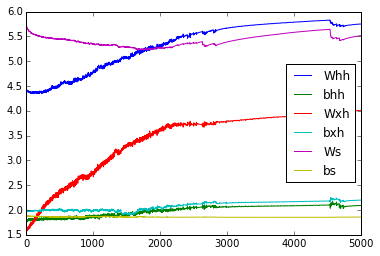

In [5]:
from collections import namedtuple

Params = namedtuple('Params', ['Whh', 'bhh', 'Wxh', 'bxh', 'Ws', 'bs'])

def parameters_generator():
    for s in states:
        yield Params(np.linalg.norm(s.Whh), np.linalg.norm(s.bhh), np.linalg.norm(s.Wxh), np.linalg.norm(s.bxh), np.linalg.norm(s.Ws), np.linalg.norm(s.bs))
        
params = list(parameters_generator())
pd.DataFrame(params, columns=Params._fields).plot()

### Magnitudes of Gradients

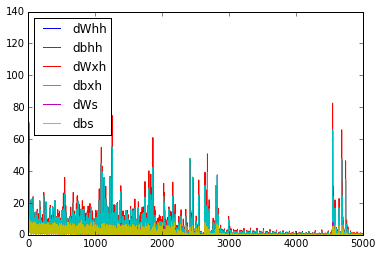

In [6]:
from collections import namedtuple

Gradients = namedtuple('Gradients', ['dWhh', 'dbhh', 'dWxh', 'dbxh', 'dWs', 'dbs'])

def gradients_generator():
    for s in states:
        yield Gradients(np.abs(s.dWhh).max(), np.abs(s.dbhh).max(), np.abs(s.dWxh).max(), np.abs(s.dbxh).max(), np.abs(s.dWs).max(), np.abs(s.dbs).max())
        
grads = list(gradients_generator())
axes = pd.DataFrame(grads, columns=Gradients._fields).plot()

### Loss

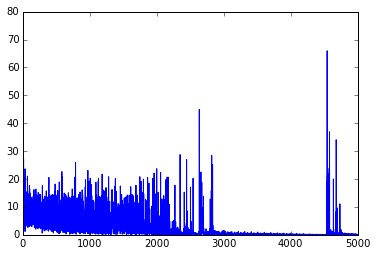

In [7]:
clf.loss.plot()

### Difference Between dhidden Local and Downstream

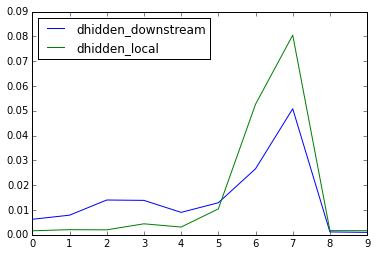

In [8]:
from collections import namedtuple

Dhiddens = namedtuple('Dhiddens', ['dhidden_downstream', 'dhidden_local'])

def dhiddens_downstream_generator():
    dhiddens = clf[['dhiddens_downstream', 'dhiddens_local']].iloc[-1]
    dhiddens_downstream = dhiddens['dhiddens_downstream']
    dhiddens_local = dhiddens['dhiddens_local']
    
    for (tstep, dhidden_downstream), (tstep, dhidden_local) in zip(dhiddens_downstream.items(), dhiddens_local.items()):
        yield Dhiddens(np.abs(dhidden_downstream).mean(), np.abs(dhidden_local).mean())
        
dhiddens = list(dhiddens_downstream_generator())
hid = pd.DataFrame(dhiddens, columns=Dhiddens._fields)
axes = hid.plot()

### Visualize

Notice the plots are linear because of the following recurrence relation:

$$v_t = x_{t+1} - x_t$$

This formula follows by definition of $x_t$:

$$x_t = x_{t-1} + v_{t-1}$$

Intuitively, as the difference between $x$ points gets smaller, the difference between $y$ points get smaller **by the same amount**

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


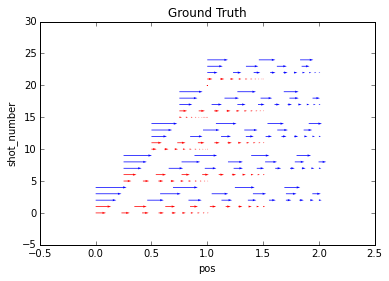

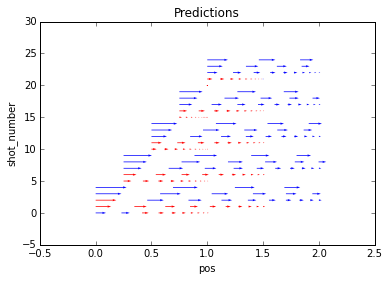

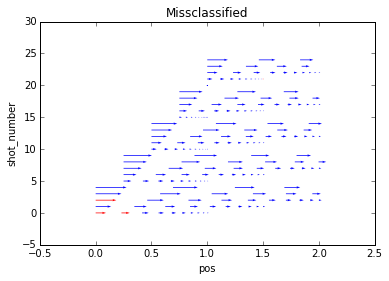

In [9]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, Whh=s.Whh, bhh=s.bhh, Wxh=s.Wxh, bxh=s.bxh, Ws=s.Ws, bs=s.bs)
    
    # Plotting
    colormap = np.array(['r', 'b', 'g'])

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    scores, predictions = rnn.predict(X)
    df['predictions'] = predictions
    axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

In [10]:
df['correct'].sum() / len(df)

0.97938144329896903